In [ ]:
# imports
import numpy as np
import random
import time
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline
from datetime import datetime
from datetime import timedelta
from itertools import islice
import statsmodels.api as sm
from os import listdir
from os.path import isfile, join
from statsmodels.nonparametric.kernel_density import KDEMultivariate
from statsmodels.nonparametric.kde import KDEUnivariate
import matplotlib.pyplot as plt
import scipy
from scipy import stats
import math
import statistics
import itertools

#font for plots
font = {'family': 'sans-serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 16,
        }

In [ ]:
import os, datetime, math, random

# os.environ["SPARK_HOME"] = "/Users/Karim/src/spark-2.0.0-bin-hadoop2.6"
os.environ["PYSPARK_PYTHON"] = "/usr/bin/python"

from KernelDensity import KernelDensity
from sklearn.linear_model import LinearRegression
from scipy import stats
from pyspark import SparkContext
from pyspark.rdd import RDD

In [ ]:
def readStocksAndFactors(prefix, numData=10):
    start = datetime.date(2008, 10, 23)
    end = datetime.date(2013, 10, 23)
    rawStocks = filter(lambda stock: len(stock) >= 260*5+10,readHistories(prefix + "stocks/", numData))
    trimmedStocks = map(lambda stock: trimToRegion(stock, start, end),rawStocks)
    
    stocks = map(lambda stock: fillInHistory(stock, start, end), trimmedStocks)
    factorsPrefix = prefix + "factors/"
    factors1 = map(lambda file: readInvestingDotComHistory(factorsPrefix + file),["crudeoil.csv", "us30yeartreasurybonds.csv"])
    factors2 = map(lambda file: readYahooHistory(factorsPrefix + file, order='inc'),['GSPC.csv','IXIC.csv'])
    trimmedFactors = map(lambda stock: trimToRegion(stock, start, end), factors1 + factors2)
    factors = map(lambda stock: fillInHistory(stock, start, end), trimmedFactors)
    stockReturns = map(twoWeekReturns, stocks)
    factorReturns = map(twoWeekReturns, factors)
    return (stockReturns, factorReturns)

def readHistories(dir, numData=10, order='des'):
    files = os.listdir(dir)
    return map(lambda f: readYahooHistory(dir+f,order), files[:numData])

def readYahooHistory(file, order='des'):
    with open(file) as f:
        lines = f.readlines()
    try:
        if "html" in lines[0]:
            print file
            return []
    except:
        pass
        
    def lineMapper(line):
        cols = line.split(',')
        try:
            date = datetime.datetime.strptime(cols[0], '%d-%b-%y').date()
        except:
            date = datetime.datetime.strptime(cols[0], '%Y-%m-%d').date()
        try: 
            value = float(cols[1])
        except:
            value = 0
        return (date, value)

    formattedLines = map(lineMapper, lines[1:])
    if order =='des':
        formattedLines.reverse() # Note: attend on the order of data's time, needed increasing
    formattedLines = [line for line in formattedLines if line[1] !=0]
    return formattedLines

def readInvestingDotComHistory(file, order='des'):
    with open(file) as f:
        lines = f.readlines()[1:]
    def lineMapper(line):
        cols = line.split(',')
        try:
            date = datetime.datetime.strptime(cols[0], '%b %d-%Y').date()
        except:
            date = datetime.datetime.strptime(cols[0], '%b %d-%Y').date()
            
        value = float(cols[1])
        return (date, value)
    formattedLines = map(lineMapper, lines)
    if order=='des':
        formattedLines.reverse()
    return formattedLines

def trimToRegion(history, start, end):
    trimmed = filter(lambda his: his[0] >= start and his[0] <= end, history)
    if(trimmed[0][0] != start):
        trimmed = [(start, trimmed[0][1])] + trimmed
    if (trimmed[-1][0] != end):
        trimmed = trimmed + [(end, trimmed[-1][1])]
    
    return trimmed

def fillInHistory(history, start, end):
    cur = history
    filled = []
    curDate = start
    count_ = 0
    idx = 0
    numEntries = len(history)
    while (curDate < end):
        while idx + 1 < numEntries and cur[idx + 1][0] <= curDate: 
            idx +=1

        filled.append((curDate, cur[idx][1]))

        curDate += datetime.timedelta(days=1)
        # skip weekend
        if (curDate.weekday()+1 > 5):
            curDate += datetime.timedelta(days=2)

    return filled

def twoWeekReturns(history):
    mappedHistory = []
    for (idx, val) in enumerate(history):
        if (idx + 10 <= len(history)):
            window = history[idx: idx + 10]
            next = window[-1][1]
            prev = window[0][1]
            mappedHistory.append((next - prev))# / prev)

    return mappedHistory

In [ ]:
start = datetime.date(2008, 10, 23)
end = datetime.date(2013, 10, 23)
(stocksReturns, factorsReturns) = readStocksAndFactors("./data/",100)

In [ ]:
# factorsReturns

In [ ]:
len(stocksReturns)

In [ ]:
try:
    sc.stop()
except:
    print("can't stop sparkcontext") 
sc = SparkContext(appName="VaR")

# Step 1: Defining relationship between market factors and instrument's returns
 ## Variance- Covariance: 

is the simplest and least computationally intensive method. The model assume that the return of each instrument is normally distributed, which allows deriving a estimate analytically

## Monte Carlo Simulation (MCS)
Monte Carlo simulation is a computerized mathematical technique that can be applied such that it is possible to account for risk in quantitative analysis and decision making. This technique is used in many different fields, such as R&D, risk management, portfolio management, pricing derivatives, strategic planning, project planning, cost modeling and many more.<br>

In general, MCS is a technique <mark style='background-color: yellow'>that "converts" uncertainty on input variables of a model into probability distributions</mark>. By combining the distributions and randomly selecting values from them, it recalculates the simulated model many times, <mark style='background-color: yellow'>to determine the probability of the output</mark>. <br>

 To capture the fact that market factors are often correlated—when NASDAQ is down, the Dow is likely to be suffering as well—we can use a multivariate normal distribution with a nondiagonal
covariance matrix:
<img src='./images/MND.png'>
Sigma: empirical covariance matrix of the return of the factors/


In [ ]:
def transpose(matrix):
    return [[matrix[j][i] for j in range(len(matrix))] for i in range(len(matrix[0]))]

assert (transpose([[1,2,3], [4,5,6], [7,8,9]]) == [[1, 4, 7], [2, 5, 8], [3, 6, 9]]), "Function transpose runs incorrectly"

In [ ]:
def featurize(factorReturns):
    squaredReturns = map(lambda x: math.copysign(1, x) * x * x, factorReturns)
    squareRootedReturns = map(lambda x: math.copysign(1,x) * math.sqrt(abs(x)), factorReturns)
    return squaredReturns + squareRootedReturns + factorReturns

# test our function featurize
assert (featurize([4, -9, 25]) == [16, -81, 625, 2, -3, 5, 4, -9, 25]), "Function runs incorrectly"

Using OLS(Odinary Least Square ), estimate the weights for each feature on each stock <br>
Weight dim?

In [ ]:
def estimateParams(y, x):
    return sm.OLS(y, x).fit().params

# transpose factorsReturns
factorMat = transpose(factorsReturns) 

# featurize each row of factorMat
factorFeatures = list(map(featurize,factorMat))

# OLS require parameter to be a numpy array
factor_columns = np.array(factorFeatures)

# add a constant - the intercept term for each instrument i.
factor_columns = sm.add_constant(factor_columns, prepend=True) 

# estimate weights
weights = [estimateParams(stockReturns, factor_columns) for stockReturns in stocksReturns] 
print("weights:", np.shape(weights))

In [ ]:
def mean_square(computedValues, realValues):
    zipped = list(zip(computedValues, realValues))
    squares = [(x[0] - x[1])**2 for x in zipped]
    return sum(squares)/len(squares)

def predict(feat, weights): 
    l = [feat[i]*weights[i] for i in range(len(feat))]
    return sum(l)

listOfMeanSquares = []
listOfVariances = []

for i in range(len(weights)):
    
    predictions = map(lambda feat: predict(feat, weights[i]), factor_columns) 
    meanError = mean_square(predictions, stocksReturns[i])
    listOfMeanSquares.append(meanError)
    varianceSquare = np.std(stocksReturns[i])**2
    listOfVariances.append(varianceSquare)
    
plt.bar(range(len(listOfMeanSquares)), listOfMeanSquares, alpha=0.4, align="center")
plt.title("Figure 1.1: Mean square error by stock")
plt.xlabel("index of stock")
plt.ylabel("Mean square error")
plt.xlim(0, len(listOfMeanSquares))
plt.show()
plt.bar(range(len(listOfVariances)), listOfVariances, alpha=0.4, align="center")
plt.title("Figure 1.2: Variance by stock")
plt.xlabel("index of stock")
plt.ylabel("Variance")
plt.xlim(0, len(listOfVariances))
plt.show() 

In [ ]:
thresholds = np.array(listOfMeanSquares)
values = np.array(listOfVariances)
x = range(len(values))

# split it up
above_threshold = np.maximum(values - thresholds, 0)
below_threshold = np.minimum(values, thresholds)
# and plot it
fig, ax = plt.subplots()
ax.bar(x, below_threshold, 0.35, color="g")
ax.bar(x, above_threshold, 0.35, color="r",
        bottom=below_threshold)

plt.title("Figure 2: Mean square error by stock with the variance")

# horizontal line indicating the threshold
ax.plot(x, thresholds, "k--")

<mark style="color: red">Comment:</mark>some flaws in our linear model for certain instruments <br>


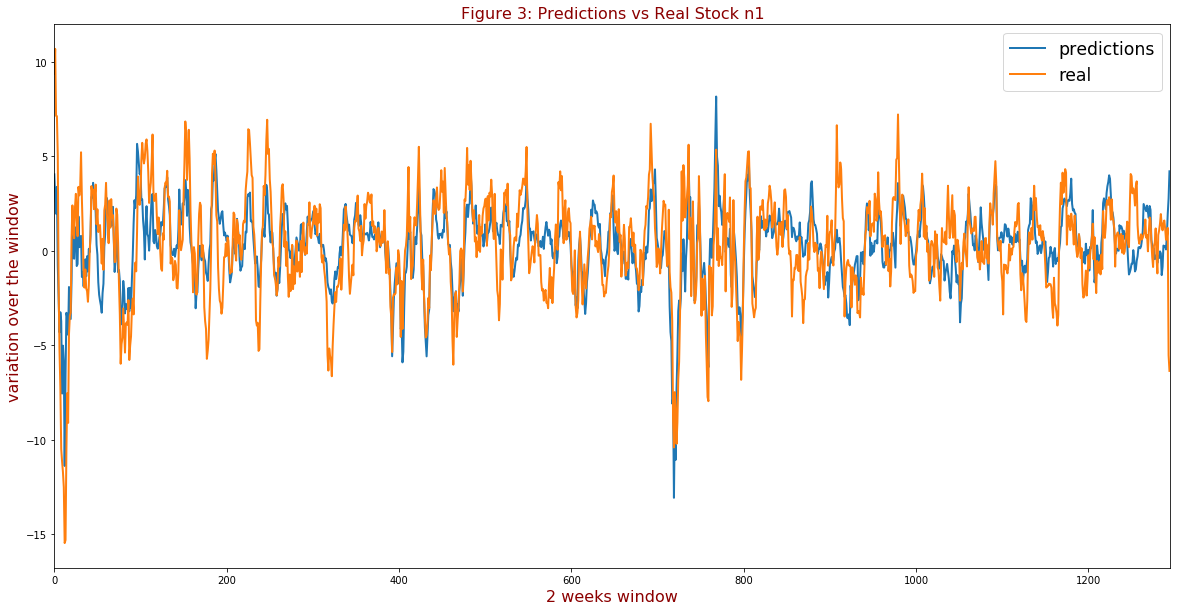

In [13]:
# handy function , parameter is just an index
def plotPredictionsVSReals(nStock):
    predictions = map(lambda x: predict(x, weights[nStock]),factor_columns)
    plt.figure(figsize=(20,10))
    plt.plot(list(predictions), lw=2)
    plt.plot(stocksReturns[nStock], lw=2)
    plt.legend(["predictions", "real"], fontsize="xx-large")
    plt.xlabel("2 weeks window", fontdict=font) 
    plt.ylabel("variation over the window", fontdict=font) 
    plt.title("Figure 3: Predictions vs Real Stock n{}".format(nStock), fontdict=font)
    plt.xlim(0, len(stocksReturns[nStock]))
    plt.show()
    
plotPredictionsVSReals(1)

<pre><mark style="color: red">Comment:</mark> <br>

<pre>

<pre><mark style="color: red">Comment:</mark> <br>
Stock that have a much high MSE have actually a wider range of variation,
Our model can't take extreme values, we're far from overfitting in th case
<pre>

# Step 2: Defining the distributions for the market conditions

# KDE: Kernel density estimation
 - A non-parametric way to estimate the probability density function of random variable.
 - a fundamental data smoothing problem
 <img src="./images/KDE.png">
 K- kernel >=0 <br>
 h- smoothing parameter-Bandwidth <br>
 K_h - Scale kernel <br>
 
 


In [16]:
def frange(x, y, jump):
  while x < y:
    yield round(x, 5)
    x += jump
    
def plotDistribution(samples, numSamples=100, plot = True):
#     return plotDistributionRDD(samples, numSamples) if isinstance(samples, RDD) else plotDistributionList(samples, numSamples=100)
    vmin = min(samples)
    vmax = max(samples)
    stddev = np.std(samples)
    
    domain = np.arange(vmin, vmax, (vmax-vmin)/numSamples)
    
    # a simple heuristic to select bandwidth
    bandwidth = 1.06 * stddev * pow(len(samples), -.2)
    
    # estimate density
    kde = KDEUnivariate(samples)
    kde.fit(bw=bandwidth)
    density = kde.evaluate(domain)
    
    # plot
    if plot ==True:
        plt.plot(domain, density)
        plt.show()
    else:
        return domain, density

def plotDistributionList(samples, numSamples=100):
    max_s = max(samples)
    min_s = min(samples)
    domain = list(frange(min_s, max_s, (max_s - min_s) / numSamples))
    densities = KernelDensity(samples).estimate(domain)
    print densities
    plt.plot(domain, densities, 'ro')
    plt.xlabel("Two Week Return ($)")
    plt.ylabel("Density")
    plt.show()

def plotDistributionRDD(samples, numSamples=100):
    stats = samples.stats()
    min_s = stats.min()
    max_s = stats.max()
    domain = list(frange(min_s, max_s, (max_s - min_s) / numSamples))
    densities = KernelDensity(samples).estimate(domain)
    plt.plot(domain, densities, 'ro')
    plt.xlabel("Two Week Return ($)")
    plt.ylabel("Density")
    plt.show()
    

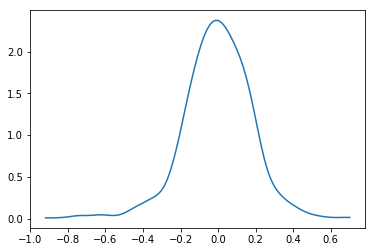

In [17]:
plotDistribution(factorsReturns[1])
# plotDistribution(factorsReturns[2])
# plotDistribution(factorsReturns[3])

## Calculate correlation between factors
The 3rd and the 4th factors are highly correlated(GSPC and IXIC)


In [ ]:
correlation = np.corrcoef(factorsReturns)
correlation

In [ ]:
factorsNames = ["crude oil", "treasury bonds", "GSPC", "IXIC"] 
f, axarr = plt.subplots(2, 2)
f.set_figwidth(20)
f.set_figheight(10)
fi = 1
for (idx,factorReturns) in enumerate(factorsReturns):
    i, j = divmod(idx, 2)
    ax = axarr[i, j]
    ax.plot(factorReturns)
    ax.set_title("Figure 5.{}:Variations over [{}, {}]: {}".format(fi,start.strftime("%D"), end.strftime("%D"), factorsNames[idx])
                , fontdict=font)
    ax.set_xlabel("2 weeks window", fontdict=font) 
    ax.set_ylabel("variation over window", fontdict=font) 
    fi +=1
f.subplots_adjust(hspace=0.3)

In [ ]:
# plot both GSPC and IXIC in same chart to observe the similarity
# f- GSPC scaled to compared the changement with IXIC
plt.figure(figsize=(20,10))
f = [x*1.7 for x in factorsReturns[2]]
plt.plot(factorsReturns[2])
plt.plot(factorsReturns[3])
plt.plot(f)
plt.legend(["GSPC linear estimation"] + factorsNames[2:4], fontsize="xx-large")
plt.xlabel("2 weeks window", fontdict=font)
plt.ylabel("Variations over window", fontdict=font)
plt.title("Figure 6: Tentative to estimate IXIC with GSPC", fontdict=font)
plt.show() 

In [ ]:
plt.figure(figsize=(20,10))
f = [x*350 for x in factorsReturns[1]]
plt.plot(factorsReturns[3])
plt.plot(f)
plt.legend(["treasury bonds linear estimation"] + factorsNames[3:4], fontsize="xx-large")
plt.xlabel("2 weeks window", fontdict=font)
plt.ylabel("Variations over window", fontdict=font)
plt.title("Figure 7: Tentative to estimate treasury bonds with GSPC", fontdict=font)
plt.show() 

<mark>Figure 6</mark> <br>
It shot that the 4th factor don't bring a lot of informations. If we want to improve model, we'll try to replace it or remove it.<br>
<mark>Figure 7</mark> <br>
The treasure bonds and IXIC are not corrolated at all

In [ ]:
factorCov = np.cov(factorsReturns)
factorMeans = [sum(factorReturns)/len(factorReturns) for factorReturns in factorsReturns]
sample = np.random.multivariate_normal(factorMeans, factorCov)

factorsNames = ["crude oil", "treasury bonds", "GSPC", "IXIC"] 
    
numSamples = 50000 # to plot normal distributions
f, axarr = plt.subplots(2, 2)
f.set_figwidth(20)
f.set_figheight(10)
fi = 1
for (idx, factorReturn) in enumerate(factorsReturns):
    i, j = divmod(idx, 2)
    ax = axarr[i, j]
    normalEstimates = [np.random.multivariate_normal(factorMeans, factorCov)[idx] for k in range(numSamples)]
    domainEstimates, densityEstimates = plotDistribution(normalEstimates, plot=False)
    domainFactor, densityFactor = plotDistribution(factorReturn, plot=False)
    ax.plot(domainEstimates, densityEstimates, lw=2)
    ax.plot(domainFactor, densityFactor, lw=2)
    ax.set_title("Figure 8.{}: Variations over [{}, {}]: {}".format(fi, start.strftime("%D"), end.strftime("%D"), factorsNames[idx])
                , fontdict=font)
    ax.set_xlabel("2 weeks window", fontdict=font) 
    ax.set_ylabel("variation over window", fontdict=font) 
    ax.legend(["estimate", "real"], fontsize="xx-large")
    fi +=1
f.subplots_adjust(hspace=0.3)

The two first factors semm to be well fitted to the model( crude oil and trasury bounds), the two others are more flawed. It shot that we should use diffirent types of probability distributions for each factor.

# Step 3&4: Generating samples, running simulation and calculating the VaR
<pre>

</pre>


In [19]:
def factorMatrix(histories):
    """
    convert factor histories matrix: (num_factors, num_windows) -> (num_windows, num_factors)
    """
    mat = [0] * len(histories[0])
    print len(histories)
    for (i, val) in enumerate(histories[0]):
        mat[i] = map(lambda h: h[i] , histories)
    return mat

def linearModel(instrument, factorMatrix):
    lm = LinearRegression()
    return lm.fit(factorMatrix, instrument)

def computeFactorWeights(stocksReturns, factorFeatures):
    linear = map(lambda s: linearModel(s, factorFeatures), stocksReturns)
    return map(lambda l: list(l.coef_), linear)

def computeTrialReturns(stocksReturns, factorsReturns, sc, baseSeed, numTrials, parallelism):
    factorMat = factorMatrix(factorsReturns)
    factorCov = np.cov(factorsReturns)
    factorMeans = map(lambda factor: sum(factor)/len(factor), factorsReturns)
    factorFeatures = map(featurize,factorMat)
    factorWeights = computeFactorWeights(stocksReturns, factorFeatures)
    bInstruments = sc.broadcast(factorWeights)
    seeds = range(baseSeed, baseSeed + parallelism)
    seedRdd = sc.parallelize(seeds, parallelism)
    print len(bInstruments.value)
    return seedRdd.flatMap(lambda s: trialReturns(s, numTrials / parallelism, bInstruments.value, factorMeans, factorCov))

def trialReturns(seed, numTrials, instruments, factorMeans, factorCovariances):
    np.random.seed(seed)
    trialReturns = [0] * numTrials
    for i in range(0, numTrials):
        trialFactorReturns = np.random.multivariate_normal(factorMeans,factorCovariances)
        trialFeatures = featurize(list(trialFactorReturns))
        trialReturns[i] = trialReturn(trialFeatures, instruments)
    return trialReturns

def trialReturn(trial, instruments):
    totalReturn = 0.0
    for instrument in instruments:
        totalReturn += instrumentTrialReturn(instrument, trial)
    return totalReturn / len(instruments)

def instrumentTrialReturn(instrument, trial):
    instrumentTrialReturn = instrument[0]
    i = 0
    while (i < len(trial)):
        instrumentTrialReturn += trial[i] * instrument[i]
        i += 1
    return instrumentTrialReturn

def fivePercentVaR(trials):
    topLosses = trials.takeOrdered(max(trials.count() / 20, 1))
    return topLosses[-1]

def fivePercentCVaR(trials):
    topLosses = trials.takeOrdered(max(trials.count() / 20, 1))
    return sum(topLosses) / len(topLosses)

def bootstrappedConfidenceInterval(trials, computeStatistic, numResamples, pValue):
    stats = sorted(map(lambda i: computeStatistic(trials.sample(True, 1.0)), range(0,numResamples)))
    lowerIndex = int(numResamples * pValue / 2 - 1)
    upperIndex = int(math.ceil(numResamples * (1 - pValue / 2)))
    return (stats[lowerIndex], stats[upperIndex])

def countFailures(stocksReturns, valueAtRisk):
    failures = 0
    for i in range(0, len(stocksReturns[0])):
        loss = sum(map(lambda x: x[i], stocksReturns))
        if(loss < valueAtRisk):
            failures += 1
    return failures

def kupiecTestStatistic(total, failures, confidenceLevel):
    failureRatio = float(failures)/ total
    logNumer = (total - failures) * math.log1p(-confidenceLevel) * failures * math.log(confidenceLevel)
    logDenom = (total - failures) * math.log1p(-failureRatio) + failures * math.log(failureRatio)
    return -2 * (logNumer - logDenom)

def kupiecTestPValue(stocksReturns, valueAtRisk, confidenceLevel):
    failures = countFailures(stocksReturns, valueAtRisk)
    total = len(stocksReturns[0])
    testStatistic = kupiecTestStatistic(total, failures, confidenceLevel)
    return 1 - stats.chi2.cdf(testStatistic, 1)


4
60
VaR 5%: -0.6975883958828157
CVaR 5%: -0.6975883958828157
VaR confidence interval: (-0.6975883958828157, -0.30599103061611355)
CVaR confidence interval: (-0.6975883958828157, 0.25623432606037577)
Kupiec test p-value: 1.0


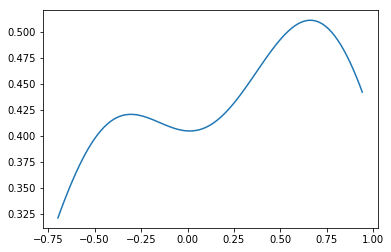

In [24]:
numTrials = 10
parallelism = 1
baseSeed = 1001L
trials = computeTrialReturns(stocksReturns, factorsReturns, sc, baseSeed, numTrials,parallelism)
trials.cache()
valueAtRisk = fivePercentVaR(trials)
conditionalValueAtRisk = fivePercentCVaR(trials)
print("VaR 5%: " + str(valueAtRisk))
print("CVaR 5%: " + str(conditionalValueAtRisk))
varConfidenceInterval = bootstrappedConfidenceInterval(trials, fivePercentVaR, 100, 0.05)
cvarConfidenceInterval = bootstrappedConfidenceInterval(trials, fivePercentCVaR, 100, 0.05)
print("VaR confidence interval: " + str(varConfidenceInterval))
print("CVaR confidence interval: " + str(cvarConfidenceInterval))
print("Kupiec test p-value: " + str(kupiecTestPValue(stocksReturns, valueAtRisk, 0.05)))
plotDistribution(trials.collect())

In [ ]:
facmat = factorMatrix(factorsReturns)
factorFeatures = map(featurize,facmat)
factorWeights = computeFactorWeights(stocksReturns, factorFeatures)

In [ ]:
print(len(factorWeights))
print(len(factorWeights[1]))

In [ ]:
len(factorsReturns)

In [ ]:
len(factorFeatures[0])

In [ ]:
len(stocksReturns)

In [23]:
trials.collect()

[0.8968994970480583,
 0.9572204731325334,
 -0.4136138144134669,
 0.8646045866670076,
 -0.6975883958828157,
 -0.30599103061611355,
 0.5226407226594225,
 0.25623432606037577,
 0.5367991203834652,
 -0.37850280150476173]